In [1]:
from plate_detection_deskewed_v2 import get_plate
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage import morphology
import os

SVM_mol = cv2.ml.SVM_load('svm.xml')

Loading model successfully...


In [7]:
test_image = "C:\\Users\\ASUS\\OneDrive\\Desktop\\plate image test\\download (5).jpg"
LpImg,Lptype, cor = get_plate(test_image)
print("Detect %i plate(s)" % len(LpImg))
print(Lptype)
print("Coordinate of plate(s) in image: \n", cor)


Detect 4 plate(s)
[2, 1, 1, 2]
Coordinate of plate(s) in image: 
 [array([[687.25761122, 761.01146776, 763.89240735, 690.13855081],
       [ 64.1439587 ,  63.39245677, 132.78848258, 133.53998451],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[357.76015359, 458.02627984, 458.53387655, 358.26775029],
       [558.01556669, 532.77438798, 560.98923971, 586.23041842],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[656.40714601, 795.38061235, 796.20767743, 657.23421109],
       [577.60920405, 578.2184651 , 617.27048227, 616.66122122],
       [  1.        ,   1.        ,   1.        ,   1.        ]]), array([[131.32122461, 340.09586687, 342.9100617 , 134.13541944],
       [ 91.73426197,  86.01348849, 207.25843045, 212.97920393],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


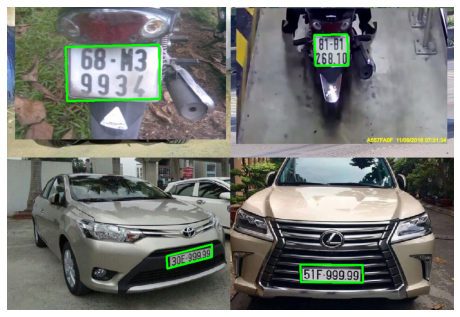

In [8]:
def draw_box(image_path,labels, cor, thickness=3):
    vehicle_image = cv2.imread(image_path)
    vehicle_image = cv2.cvtColor(vehicle_image,cv2.COLOR_BGR2RGB)
    # store the top-left, top-right, bottom-left, bottom-right
    # of the plate license respectively
    for j in range(len(cor)):
        pts = []
        x_coordinates = cor[j][0]
        y_coordinates = cor[j][1]
        for i in range(4):
            pts.append([int(x_coordinates[i]), int(y_coordinates[i])])

        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1, 1, 2))
        # print(pts[0][0])
        vehicle_image = cv2.polylines(
            vehicle_image, [pts], True, (0, 255, 0), thickness)
        if len(labels):
            vehicle_image = cv2.putText(vehicle_image,str(labels[j]),pts[0][0], cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return vehicle_image


plt.figure(figsize=(8, 8))
plt.axis(False)
plt.imshow(draw_box(test_image,[], cor))


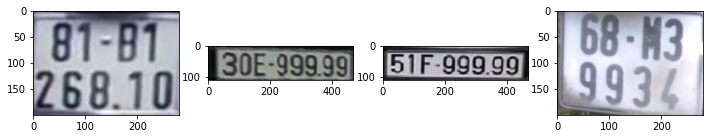

In [9]:
plt.figure(figsize=(12, 5))
for i in range(len(LpImg)):
    plt.subplot(1, 4, i+1)
    plt.imshow(LpImg[i])

In [10]:
class Character_segment:
    
    def __init__(self, img, plateType,model):
        self.model = model
        self.plateImg = img
        self.height = self.plateImg.shape[0]
        self.plateType = plateType
        self.char_h = 60
        self.char_w = 30
        self.plate_string = ""
        self.extract()

    def processing(self):
        # First we read input image, later convert into HSV
        # Split to take V channel and apply local binary threshold on it
        # Use canny to find boundaries and dilate to thicken them
        # self.readImage()
        raw_img = self.plateImg

        V = cv2.split(cv2.cvtColor(raw_img, cv2.COLOR_BGR2HSV))[2]

        T = threshold_local(V, block_size=65, offset=15, method='gaussian')
        thresh = (V > T).astype("uint8")*255
        thresh = cv2.bitwise_not(thresh)

        self.plateImg = thresh

        opening = morphology.area_opening(thresh, area_threshold=512)
        closing = morphology.area_closing(opening, area_threshold=512)

        canny = cv2.Canny(closing, 0, 255, 1)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
        dilate = cv2.dilate(canny, kernel, iterations=1)
        return dilate

    def extract(self):
        img = self.processing()
        contours = cv2.findContours(
            img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        # print(len(contours))
        upper = []
        lower = []

        if self.plateType == 1:
            plateH = 110
        elif self.plateType == 2:
            plateH = 200

        #extract characters
        for contour in contours:
            area = cv2.contourArea(contour)
            # if area >200:
            x, y, w, h = cv2.boundingRect(contour)
            if self.plateType == 2:
                if h/w > 1 and h/w <= 4 and h/plateH >= 1/5 and h/plateH <= 1/2:
                    if y <= self.height/3:
                        upper.append([x, y, w, h])
                    else:
                        lower.append([x, y, w, h])
            else:
                if h/w >= 0.5 and h/w <= 5 and h/plateH >= 1/3:
                    upper.append([x, y, w, h])
                        
        upper = sorted(upper, key=self.takeX)
        lower = sorted(lower, key=self.takeX)
        full = upper+lower

        # print(len(full))
        
        plt.figure(figsize=(12, 12))
        image_number = 1

        plate_string = ""
        for i in range(len(full)):
            x = full[i][0]
            y = full[i][1]
            w = full[i][2]
            h = full[i][3]
            roi = self.plateImg[y:y+h, x:x+w]
            roi = cv2.resize(roi,(self.char_w,self.char_h))
            plt.subplot(8, 8, image_number)
            plt.imshow(roi, cmap='gray')
            roi = np.array(roi, dtype=np.float32)
            roi = roi.reshape(-1, 30 * 60)
            pred = self.model.predict(roi)[1][0][0]
            if pred < 10:
                char = str(int(pred))
            else:
                char = str(chr(pred))
            plate_string+=char
            plt.title("{}".format(char))
            image_number += 1
        print('Plate numbers:',plate_string)
        self.plate_string = plate_string

    def takeX(sefl, a):
        return a[0]


Plate numbers: 81B126810
Plate numbers: 30E999990
Plate numbers: 51F99999
Plate numbers: 68M39934


<Figure size 864x864 with 0 Axes>

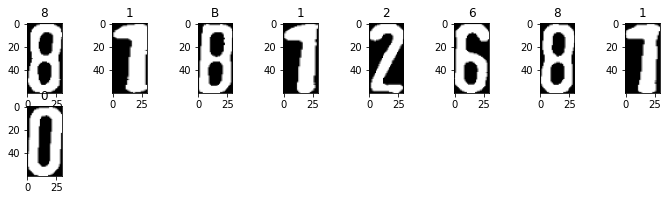

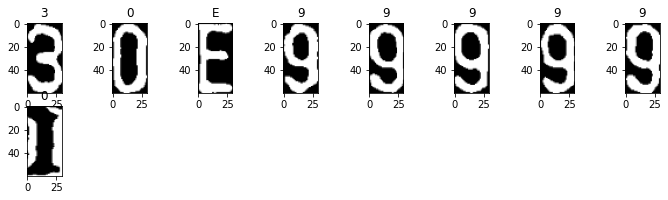

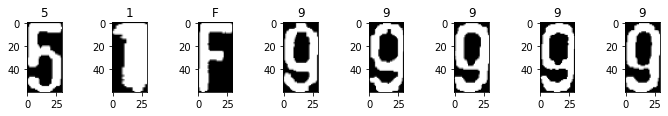

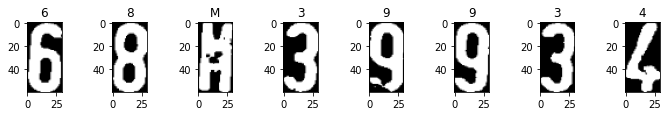

In [11]:
plt.figure(figsize=(12,12))
plate_string = []
for i in range(len(LpImg)):
    img = np.array(LpImg[i]*255,dtype = np.float32)
    plateType = Lptype[i]
    plate_string.append(Character_segment(img, plateType, SVM_mol).plate_string)
